# Windfields

This notebook is for downloading typhoon tracks from
IBTrACS and generating the windfields.

TODOs:

- Get the full list of track IDs from IBTraCS (link is below)
- Add interpolation between the timesteps
- Understand if we need to change any of the input parameters
  to the climada methods
- Aggregate up to a 0.1 deg grid and save output

In [1]:
%load_ext jupyter_black

In [49]:
from pathlib import Path
import os

from climada.hazard import Centroids, TCTracks, TropCyclone
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr

## Get typhoon data

Typhoon IDs from IBTrACS are taken from 
[here](https://ncics.org/ibtracs/index.php?name=browse-name)

In [22]:
# TODO: It would be better to turn this into a Excel or
# csv file with a separate year, name, and typhoon ID,
# then read that in as a Pandas dataframe
new_typhoon_id_dict = {}
# Typhoons' name and Id
typhoon_id_dict = {
    "2006329N06150": "DURIAN",
    "2008169N08135": "FENGSHEN",
    "2009268N14128": "KETSANA",
    "2010191N12138": "CONSON",
    "2011266N13139": "NESAT",
    "2012331N03157": "BOPHA",
    "2013282N14132": "NARI",
    "2013301N13142": "KROSA",
    "2013306N07162": "HAIYAN",
    "2013259N17132": "USAGI",
    "2013220N12137": "UTOR",
    "2014362N07130": "JANGMI",
    "2014254N10142": "KALMAEGI",
    "2014190N08154": "RAMMASUN",
    "2014334N02156": "HAGUPIT",
    "2014260N13135": "FUNG-WONG",
    "2014015N10129": "LINGLING",
    "2015273N12130": "MUJIGAE",
    "2015344N07145": "MELOR",
    "2015122N07144": "NOUL",
    "2015226N12151": "GONI",
    "2015183N13130": "LINFA",
    "2015285N14151": "KOPPU",
    "2015012N09146": "MEKKHALA",
    "2016288N07145": "HAIMA",
    "2016328N09130": "TOKAGE",
    "2016253N13144": "MERANTI",
    "2016355N07146": "NOCK-TEN",
    "2016287N13130": "SARIKA",
    "2018250N12170": "MANGKHUT",
    "2018294N08161": "YUTU",
    "2019329N09160": "KAMMURI",
    "2019308N13114": "NAKRI",
    "2019354N05151": "PHANFONE",
    "2020291N06141": "SAUDEL",
    "2020299N11144": "GONI",
    "2020313N08135": "VAMCO",
    "2020129N07134": "VONGFONG",
    "2020296N09137": "MOLAVE",
}

for i in range(len(typhoon_id_dict)):
    typhoon_year = list(typhoon_id_dict.keys())[i][0:4]
    new_key = list(typhoon_id_dict.values())[i] + typhoon_year
    new_typhoon_id_dict[new_key] = list(typhoon_id_dict.keys())[i]

print(new_typhoon_id_dict)

{'DURIAN2006': '2006329N06150', 'FENGSHEN2008': '2008169N08135', 'KETSANA2009': '2009268N14128', 'CONSON2010': '2010191N12138', 'NESAT2011': '2011266N13139', 'BOPHA2012': '2012331N03157', 'NARI2013': '2013282N14132', 'KROSA2013': '2013301N13142', 'HAIYAN2013': '2013306N07162', 'USAGI2013': '2013259N17132', 'UTOR2013': '2013220N12137', 'JANGMI2014': '2014362N07130', 'KALMAEGI2014': '2014254N10142', 'RAMMASUN2014': '2014190N08154', 'HAGUPIT2014': '2014334N02156', 'FUNG-WONG2014': '2014260N13135', 'LINGLING2014': '2014015N10129', 'MUJIGAE2015': '2015273N12130', 'MELOR2015': '2015344N07145', 'NOUL2015': '2015122N07144', 'GONI2015': '2015226N12151', 'LINFA2015': '2015183N13130', 'KOPPU2015': '2015285N14151', 'MEKKHALA2015': '2015012N09146', 'HAIMA2016': '2016288N07145', 'TOKAGE2016': '2016328N09130', 'MERANTI2016': '2016253N13144', 'NOCK-TEN2016': '2016355N07146', 'SARIKA2016': '2016287N13130', 'MANGKHUT2018': '2018250N12170', 'YUTU2018': '2018294N08161', 'KAMMURI2019': '2019329N09160', 'NA

In [6]:
# Download all tracks from the west pacific basin
sel_ibtracs = TCTracks.from_ibtracs_netcdf(
    provider="usa", year_range=(2006, 2022), basin="WP"
)
sel_ibtracs.size

2022-11-22 14:23:44,571 - climada.hazard.tc_tracks - WARNING - 18 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


In [47]:
# Get_track returns the first matching track based
# on the track ID. Interpolate from 3 hours to
# 30 minute intervals to create a smooth intensity field.
tc_tracks = TCTracks()
for typhoon_id in new_typhoon_id_dict.values():
    tc_track = sel_ibtracs.get_track(typhoon_id).interp(
        time=pd.date_range(
            track.time.values[0], track.time.values[-1], freq="30T"
        )
    )
    tc_tracks.append(tc_track)

display(tc_tracks.data[:1])

[<xarray.Dataset>
 Dimensions:                 (time: 733)
 Coordinates:
     lat                     (time) float64 6.1 6.118 6.137 ... 11.66 11.68 11.7
     lon                     (time) float64 149.8 149.7 149.6 ... 81.93 81.8
   * time                    (time) datetime64[ns] 2006-11-24T12:00:00 ... 200...
 Data variables:
     time_step               (time) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
     radius_max_wind         (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     radius_oci              (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     max_sustained_wind      (time) float64 15.0 15.0 15.0 ... 15.0 15.0 15.0
     central_pressure        (time) float64 1.006e+03 1.006e+03 ... 1.006e+03
     environmental_pressure  (time) float64 1.008e+03 1.008e+03 ... 1.006e+03
     basin                   (time) <U2 'WP' 'WP' 'WP' 'WP' ... 'NI' 'NI' 'NI'
 Attributes:
     max_sustained_wind_unit:  kn
     central_pressure_unit:    mb
     name:                     DURIA

<GeoAxesSubplot:>

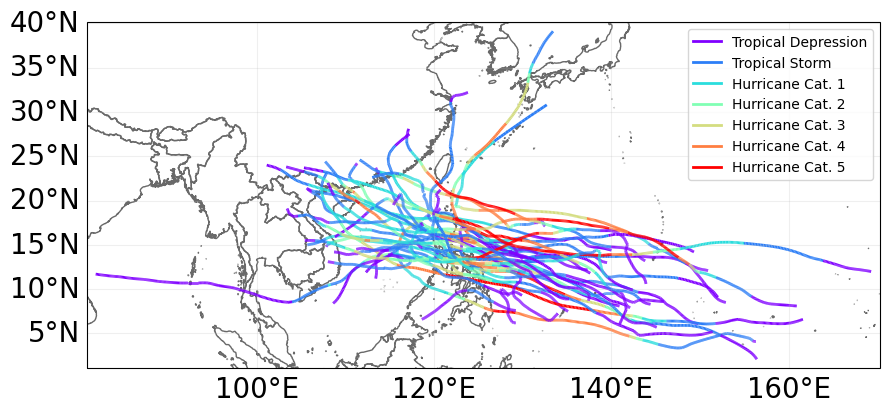

In [46]:
# Plot the tracks
# Takes awhile, especially after the interpolation.
tc_track_list.plot()

## Construct the windfield

The typhoon tracks will be used to construct the wind field.
The wind field grid will be set using a geopackage file that is
used for all other grid-based data.

In [67]:
input_dir = (
    Path(os.getenv("STORM_DATA_DIR")) / "analysis/02_new_model_input/input"
)
filepath = input_dir / "phil_0.1_degree_grid.gpkg"
gdf = gpd.read_file(filepath)

gdf

,id,left,top,right,bottom,Area,AreainKM,Len,Longitude,Latitude,Centroid,geometry
0,1.0,114.25,21.15,114.35,21.05,1.150374e+08,115.037,10.72555,114.3,21.1,114.3E_21.1N,"MULTIPOLYGON (((114.25000 21.15000, 114.35000 ..."
1,2.0,114.25,21.05,114.35,20.95,1.151129e+08,115.113,10.72907,114.3,21.0,114.3E_21N,"MULTIPOLYGON (((114.25000 21.05000, 114.35000 ..."
2,3.0,114.25,20.95,114.35,20.85,1.151881e+08,115.188,10.73257,114.3,20.9,114.3E_20.9N,"MULTIPOLYGON (((114.25000 20.95000, 114.35000 ..."
3,4.0,114.25,20.85,114.35,20.75,1.152629e+08,115.263,10.73606,114.3,20.8,114.3E_20.8N,"MULTIPOLYGON (((114.25000 20.85000, 114.35000 ..."
4,5.0,114.25,20.75,114.35,20.65,1.153373e+08,115.337,10.73952,114.3,20.7,114.3E_20.7N,"MULTIPOLYGON (((114.25000 20.75000, 114.35000 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
20745,20746.0,126.65,5.05,126.75,4.95,1.226348e+08,122.635,11.07406,126.7,5.0,126.7E_5N,"MULTIPOLYGON (((126.65000 5.05000, 126.75000 5..."
20746,20747.0,126.65,4.95,126.75,4.85,1.226529e+08,122.653,11.07488,126.7,4.9,126.7E_4.9N,"MULTIPOLYGON (((126.65000 4.95000, 126.75000 4..."
20747,20748.0,126.65,4.85,126.75,4.75,1.226705e+08,122.671,11.07567,126.7,4.8,126.7E_4.8N,"MULTIPOLYGON (((126.65000 4.85000, 126.75000 4..."
20748,20749.0,126.65,4.75,126.75,4.65,1.226879e+08,122.688,11.07646,126.7,4.7,126.7E_4.7N,"MULTIPOLYGON (((126.65000 4.75000, 126.75000 4..."


In [68]:
# TODO: this should work once Pauline converts the 
# multipolygon data to centroids

cent = Centroids.from_geodataframe(gpd.read_file(filepath))

cent.check()
cent.plot();

ValueError: y attribute access only provided for Point geometries

In [15]:
# construct tropical cyclones
tc = TropCyclone.from_tracks(
    tc_track_list, centroids=cent, store_windfields=True
)

2022-11-22 14:05:03,417 - climada.util.plot - WARNING - Error parsing coordinate system 'EPSG:4326'. Using projection PlateCarree in plot.


<GeoAxesSubplot:title={'center':'Event ID 7: 2013282N14132'}>

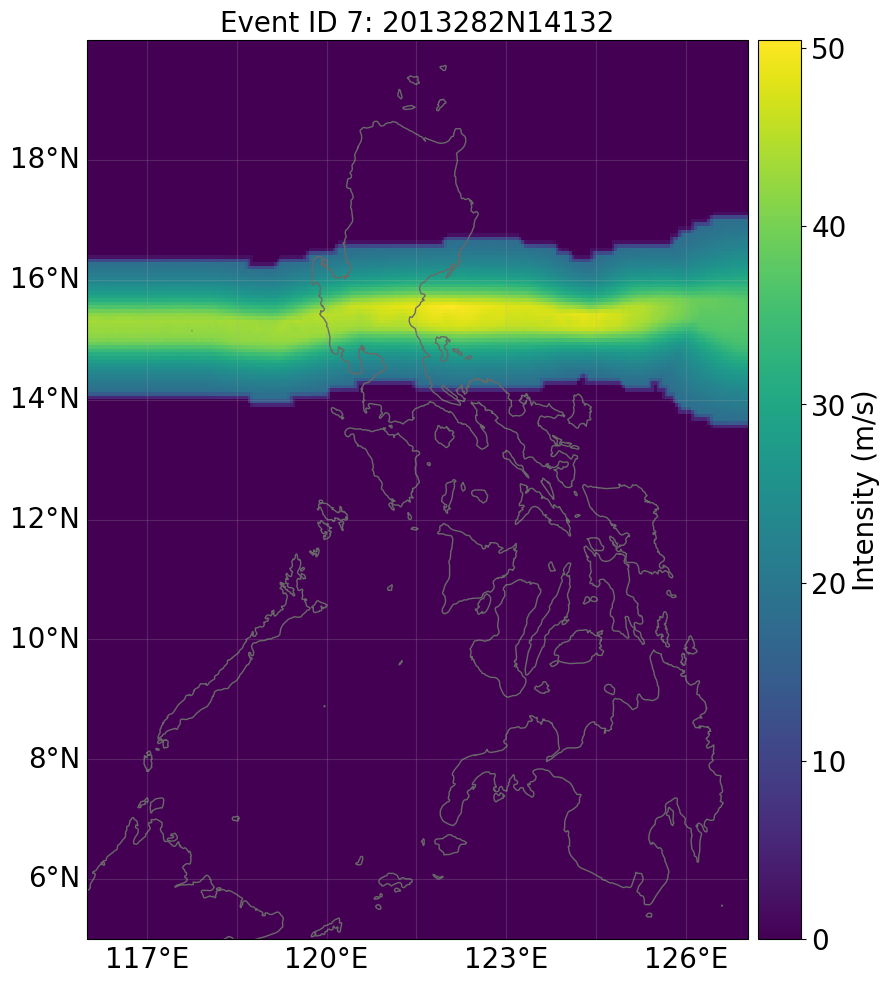

In [57]:
# Let's look at the first typhoon in the dictionary as an example.

tc.plot_intensity(new_typhoon_id_dict["NARI2013"])

In [58]:
# Then calculate windfield
intensity = tc.intensity

In [59]:
tc.intensity

<39x11718 sparse matrix of type '<class 'numpy.float64'>'
	with 81390 stored elements in Compressed Sparse Row format>

In [60]:
windfield_data = intensity.data
windfield_data

array([18.47241286, 18.15957914, 17.8690079 , ..., 17.65572339,
       17.97236532, 17.68126776])

In [61]:
import scipy.sparse

scipy.sparse.save_npz("sparse_matrix.npz", tc.intensity, compressed=True)

In [62]:
sparse_matrix = scipy.sparse.load_npz("sparse_matrix.npz")

In [63]:
sparse_matrix.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [29.7217212 , 29.82215779, 29.39314909, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [69]:
# TODO: We want to create an output that is a geodataframe with the
# following columns:
#
# Grid point ID
# Grid point centroid
# Typhoon name
# Typhoon year
# Wind speed
#
# From the info we have now, you can create a data frame with the last
# three columns. Then, once Pauline creates a centroid grid,
# you can add the first two columns.